In [1]:
import numpy as np
from matplotlib import pyplot
import os
import re
import multiprocessing as mp
import itertools

In [2]:
files = os.listdir("../data/np_train/")

In [3]:
chrs = [str(i) for i in range(1, 23)] + ["X"]

In [4]:
def parse_name(fname):
    line, assay, chrom = re.match("(\d+)_(\d+)_chr(.*?)\.npy", fname).groups()
    return int(line), int(assay), chrom

In [24]:
def dot(arr1, arr2):
    iters = (iter(arr1), iter(arr2))
    s1, e1, v1 = next(iters[0])
    s2, e2, v2 = next(iters[1])
    
    total = 0
    arr1_total = 0
    arr2_total = 0
    try:
        while True:
            while s1 >= e2 or s2 >= e1:
                if s1 >= e2:
                    # advance second interval
                    s2, e2, v2 = next(iters[1])

                if s2 >= e1:
                    # advance first interval
                    s1, e1, v1 = next(iters[0])
            start = max(s1, s2)
            end = min(e1, e2)
            total += (end - start) * v1 * v2
            arr1_total += (end - start) * v1
            arr2_total += (end - start) * v2
            
            if end == e1:
                s1, e1, v1 = next(iters[0])
            if end == e2:
                s2, e2, v2 = next(iters[1])
    except StopIteration:
        return total, arr1_total, arr2_total

In [6]:
def get_assay_files(assay_name):
    return [name for name in files if f"_{assay_name}_" in name]
    
def dot_helper(assay1, assay2, line, chrom):
    arr1 = np.load(f"../data/np_train/{line}_{assay1}_chr{chrom}.npy", mmap_mode="r")
    arr2 = np.load(f"../data/np_train/{line}_{assay2}_chr{chrom}.npy", mmap_mode="r")
    val = dot(arr1, arr2)
    print("Completed:", assay1, assay2, line, chrom)
    return val
    
def dot_assays(assay1, assay2):
    # get list of cell lines in common
    assay1_files = get_assay_files(assay1)
    assay2_files = get_assay_files(assay2)
    
    assay1_lines = set(line for line, _, _ in map(parse_name, assay1_files))
    assay2_lines = set(line for line, _, _ in map(parse_name, assay2_files))
    tasks = ((assay1, assay2) + v for v in itertools.product(assay1_lines & assay2_lines, chrs))

    totals = zip(*[dot_helper(*t) for t in tasks])
    total, arr1_total, arr2_total = [sum(i) for i in totals]
    print("Assay Completed:", assay1, assay2)
    return assay1, assay2, total, len(assay1_lines & assay2_lines)


def get_line_files(line):
    return [name for name in files if parse_name(name)[0] == line]

def dot_lines(line1, line2):
    line1_files = get_line_files(line1)
    line2_files = get_line_files(line2)
    line1_assays = set(assay for _, assay, _ in map(parse_name, line1_files))
    line2_assays = set(assay for _, assay, _ in map(parse_name, line2_files))
    overlap = line1_assays & line2_assays
    
    total = 0
    for assay in overlap:
        for chrom in chrs:
            arr1 = np.load(f"../data/np_train/{line1}_{assay}_chr{chrom}.npy", mmap_mode="r")
            arr2 = np.load(f"../data/np_train/{line2}_{assay}_chr{chrom}.npy", mmap_mode="r")
            total += dot(arr1, arr2)
            print("Finished:", line1, line2, assay, chrom)
    return line1, line2, total, len(overlap)

In [7]:
%%time
dot_prods = np.zeros((35, 35), dtype=np.double)
lines = np.zeros((35, 35), dtype=np.int32)
tasks = []
for i in range(1, 36):
    for j in range(i, 36):
        tasks.append((i, j))

with mp.Pool(min(len(tasks), 128)) as pool:
    results = pool.starmap(dot_assays, tasks)
for assay1, assay2, total, count in results:
    dot_prods[assay1 - 1, assay2 - 1] = total
    lines[assay1 - 1, assay2 - 1] = count

Assay Completed: 1 3
Assay Completed: 1 7
Assay Completed: 1 11
Assay Completed: 1 9
Assay Completed: 1 15
Assay Completed: 1 5
Assay Completed: 1 4
Assay Completed: 1 21
Assay Completed: 1 13
Assay Completed: 1 23
Assay Completed: 1 27
Assay Completed: 1 31
Assay Completed: 1 19
Assay Completed: 1 35
Assay Completed: 2 11
Assay Completed: 1 25
Assay Completed: 1 12
Assay Completed: 1 33
Assay Completed: 1 8
Assay Completed: 1 10
Assay Completed: 1 6
Assay Completed: 1 24
Assay Completed: 1 14
Assay Completed: 3 14
Assay Completed: 1 28
Assay Completed: 1 22
Assay Completed: 1 32
Assay Completed: 1 26
Assay Completed: 1 34
Assay Completed: 5 7
Assay Completed: 4 30
Assay Completed: 5 31
Assay Completed: 5 11
Assay Completed: 5 15
Assay Completed: 6 11
Assay Completed: 7 30
Assay Completed: 7 28
Assay Completed: 9 31
Assay Completed: 7 32
Assay Completed: 4 28
Assay Completed: 9 11
Assay Completed: 8 28
Assay Completed: 8 30
Assay Completed: 8 31
Assay Completed: 10 11
Completed: 9 12 2

Completed: 8 10 17 3
Completed: 2 31 46 4
Completed: 9 13 17 3
Completed: 4 14 32 2
Completed: 3 10 17 4
Completed: 6 35 32 3
Completed: 8 29 27 4
Completed: 2 29 32 2
Completed: 6 12 27 6
Completed: 3 12 18 6
Completed: 4 6 32 3
Completed: 2 12 18 2
Completed: 6 31 46 4
Completed: 9 35 17 3
Completed: 7 34 32 3
Completed: 2 25 17 3
Completed: 9 23 17 3
Completed: 7 14 32 3
Completed: 6 15 17 5
Completed: 3 6 17 5
Completed: 9 12 23 8
Completed: 7 8 17 4
Completed: 6 19 32 3
Completed: 3 34 17 7
Completed: 5 33 23 4
Completed: 4 26 32 4
Completed: 5 25 23 3
Completed: 2 23 17 3
Completed: 7 10 32 3
Completed: 6 23 17 3
Completed: 3 8 17 4
Completed: 8 24 17 4
Completed: 8 12 27 4
Completed: 5 5 23 3
Completed: 6 9 17 5
Completed: 1 16 2 2
Completed: 2 13 32 3
Completed: 7 24 32 3
Completed: 9 21 17 5
Completed: 3 30 18 9
Completed: 9 33 17 5
Completed: 5 35 23 3
Completed: 8 32 23 3
Completed: 9 32 23 6
Completed: 8 16 17 4
Completed: 7 33 17 6
Completed: 1 1 2 2
Completed: 9 19 23 6
C

Completed: 6 9 17 8
Completed: 3 15 17 11
Completed: 8 29 27 8
Completed: 6 19 32 5
Completed: 7 33 17 12
Completed: 8 10 17 6
Completed: 6 35 32 6
Completed: 4 20 27 6
Completed: 3 10 17 8
Completed: 3 34 17 14
Completed: 3 8 17 7
Completed: 2 35 32 5
Completed: 5 12 23 5
Completed: 8 12 27 7
Completed: 5 35 23 5
Completed: 6 33 17 9
Completed: 9 35 17 6
Completed: 1 20 2 3
Completed: 5 9 23 6
Completed: 3 26 12 4
Completed: 9 12 23 15
Completed: 5 21 23 5
Completed: 3 12 18 12
Completed: 9 32 23 11
Completed: 4 10 32 5
Completed: 4 4 32 7
Completed: 2 13 32 5
Completed: 6 7 32 5
Completed: 4 32 23 11
Completed: 3 30 18 15
Completed: 8 18 17 9
Completed: 8 14 27 7
Completed: 9 15 17 8
Completed: 7 12 27 7
Completed: 2 33 17 7
Completed: 6 21 32 6
Completed: 7 34 32 6
Completed: 9 9 17 9
Completed: 4 6 32 6
Completed: 3 4 46 9
Completed: 9 13 17 6
Completed: 8 32 23 6
Completed: 6 17 32 5
Completed: 7 24 32 6
Completed: 6 25 17 8
Completed: 9 17 17 9
Completed: 6 15 17 10
Completed: 2 

Completed: 3 12 18 17
Completed: 5 13 23 8
Completed: 2 23 17 8
Completed: 3 15 17 18
Completed: 2 19 32 7
Completed: 3 34 17 X
Completed: 4 20 27 9
Completed: 6 7 32 7
Completed: 2 13 32 7
Completed: 5 23 23 7
Completed: 4 12 27 10
Completed: 5 33 23 10
Completed: 7 18 32 7
Completed: 4 16 32 7
Completed: 9 21 17 14
Completed: 3 30 18 X
Assay Completed: 3 30
Completed: 3 16 34 3
Completed: 5 16 23 9
Completed: 3 8 17 11
Completed: 4 24 32 8
Completed: 7 20 17 4
Completed: 4 4 32 10
Completed: 2 33 17 10
Completed: 6 29 32 6
Completed: 2 9 17 7
Completed: 7 31 46 13
Completed: 2 25 17 8
Completed: 6 33 17 13
Completed: 8 12 27 10
Completed: 8 18 17 13
Completed: 9 19 23 18
Completed: 8 34 17 17
Completed: 4 32 23 17
Completed: 6 15 17 14
Completed: 7 34 32 8
Completed: 6 27 23 7
Completed: 8 29 27 12
Completed: 5 17 23 9
Completed: 4 34 32 8
Completed: 6 9 17 11
Completed: 6 31 46 14
Completed: 3 10 17 12
Completed: 9 35 17 9
Completed: 6 13 32 10
Completed: 5 21 23 8
Completed: 2 21 3

Completed: 9 17 17 20
Completed: 4 29 32 9
Completed: 7 20 17 5
Completed: 6 15 17 18
Completed: 4 12 27 13
Completed: 6 33 17 17
Completed: 7 18 32 9
Completed: 2 21 32 10
Completed: 2 25 17 11
Completed: 9 15 17 15
Completed: 2 3 24 10
Completed: 4 24 32 10
Completed: 4 4 32 13
Completed: 3 34 18 2
Completed: 5 12 23 10
Completed: 8 18 17 18
Completed: 3 31 46 2
Completed: 5 19 23 11
Completed: 2 27 24 12
Completed: 8 8 17 21
Completed: 1 16 2 6
Completed: 3 24 17 22
Completed: 2 12 18 8
Completed: 7 14 32 10
Completed: 5 8 23 9
Completed: 9 17 17 21
Completed: 6 31 46 18
Completed: 9 33 17 18
Completed: 7 12 27 13
Completed: 9 23 17 11
Completed: 3 6 17 18
Completed: 8 32 23 11
Completed: 8 12 27 13
Completed: 6 23 17 10
Completed: 8 24 17 15
Completed: 3 4 46 16
Completed: 6 35 32 11
Completed: 7 26 32 12
Completed: 2 2 2 5
Completed: 8 26 17 17
Completed: 9 21 17 20
Completed: 3 32 24 14
Completed: 10 12 27 14
Completed: 2 17 32 8
Completed: 3 28 34 4
Completed: 9 9 17 20
Complete

Completed: 9 21 23 1
Completed: 3 8 17 20
Completed: 8 26 17 X
Assay Completed: 8 26
Completed: 4 12 27 17
Completed: 3 4 46 20
Completed: 7 34 32 13
Completed: 1 29 2 7
Completed: 2 12 18 10
Completed: 8 34 27 2
Completed: 4 34 32 13
Completed: 4 16 32 11
Completed: 7 8 17 18
Completed: 5 33 23 17
Completed: 4 22 32 10
Completed: 6 25 17 20
Completed: 3 18 34 5
Completed: 3 22 34 5
Completed: 6 9 17 19
Completed: 2 15 17 19
Completed: 7 29 32 11
Completed: 4 10 32 12
Completed: 8 14 27 19
Completed: 8 16 17 21
Completed: 9 25 17 17
Completed: 5 19 23 14
Completed: 7 12 27 17
Completed: 3 31 46 5
Completed: 4 4 32 17
Completed: 7 18 32 11
Completed: 8 8 27 2
Completed: 5 25 23 15
Completed: 2 3 24 13
Completed: 3 8 17 21
Completed: 4 20 27 15
Completed: 3 4 46 21
Completed: 2 27 24 16
Completed: 2 31 46 13
Completed: 5 13 23 14
Completed: 7 20 17 6
Completed: 2 25 17 14
Completed: 3 32 24 18
Completed: 6 25 17 21
Completed: 5 16 23 15
Completed: 6 19 32 12
Completed: 7 31 46 22
Complet

Completed: 7 12 27 22
Completed: 5 5 23 18
Completed: 5 25 23 19
Completed: 9 33 23 3
Completed: 2 3 24 16
Completed: 4 4 32 X
Completed: 2 7 32 12
Completed: 2 31 46 16
Completed: 7 26 32 19
Completed: 2 33 17 22
Completed: 5 23 23 14
Completed: 9 16 17 1
Completed: 5 19 23 17
Completed: 5 8 23 13
Completed: 8 34 27 4
Completed: 6 17 32 12
Completed: 8 10 17 22
Completed: 3 9 17 1
Completed: 5 27 23 11
Completed: 2 21 32 16
Completed: 5 17 23 18
Completed: 2 9 17 14
Completed: 4 10 32 15
Completed: 5 12 23 16
Completed: 9 27 23 22
Completed: 6 12 46 2
Completed: 9 13 17 20
Completed: 4 24 32 16
Completed: 2 13 32 13
Completed: 9 23 17 18
Completed: 5 9 23 19
Completed: 5 33 23 22
Completed: 6 25 46 1
Completed: 7 20 17 7
Completed: 5 13 23 17
Completed: 4 8 27 21
Completed: 6 19 32 15
Completed: 9 35 17 21
Completed: 4 26 32 22
Completed: 9 17 23 5
Completed: 7 10 32 15
Completed: 6 7 32 16
Completed: 2 17 32 12
Completed: 5 29 23 16
Completed: 9 9 23 7
Completed: 6 13 32 20
Completed

Completed: 8 32 23 21
Completed: 9 9 23 13
Completed: 5 12 23 21
Completed: 6 29 32 14
Completed: 1 17 20 10
Completed: 4 16 32 16
Completed: 9 33 23 6
Completed: 4 10 32 18
Completed: 8 18 27 4
Completed: 4 6 32 19
Completed: 7 34 32 21
Completed: 1 20 2 9
Completed: 2 29 32 14
Completed: 7 20 17 8
Completed: 7 26 17 1
Completed: 7 10 32 18
Completed: 8 16 27 3
Completed: 5 21 23 22
Completed: 2 3 24 19
Completed: 2 9 17 17
Completed: 4 24 32 20
Completed: 2 7 32 15
Completed: 6 35 32 22
Completed: 7 14 32 19
Completed: 1 16 2 10
Completed: 6 17 32 15
Completed: 5 8 23 16
Completed: 2 23 17 19
Completed: 9 20 17 2
Completed: 7 24 32 X
Completed: 2 2 2 8
Completed: 3 18 34 7
Completed: 8 34 27 7
Completed: 1 29 2 10
Completed: 4 34 32 22
Completed: 2 21 32 20
Completed: 7 34 32 22
Completed: 10 15 17 10
Completed: 9 9 23 14
Completed: 4 26 46 1
Completed: 3 22 34 7
Completed: 5 29 23 20
Completed: 9 16 17 3
Completed: 5 35 23 18
Completed: 9 17 23 9
Completed: 4 8 23 1
Completed: 2 13 

Completed: 2 9 17 X
Completed: 3 24 18 11
Completed: 9 13 23 4
Completed: 5 20 23 1
Completed: 4 18 32 19
Completed: 10 35 32 1
Completed: 2 29 32 17
Completed: 9 21 23 10
Completed: 8 24 23 4
Completed: 4 29 32 19
Completed: 9 23 23 2
Completed: 3 31 46 15
Completed: 4 14 32 21
Completed: 9 17 23 13
Completed: 7 8 27 5
Completed: 6 25 46 6
Completed: 9 35 23 3
Completed: 2 19 32 21
Completed: 4 22 32 18
Completed: 5 8 23 20
Completed: 2 5 23 20
Completed: 5 14 23 1
Completed: 7 29 32 20
Completed: 10 25 17 5
Completed: 2 13 32 19
Completed: 7 34 17 3
Completed: 4 16 32 22
Completed: 5 35 23 X
Assay Completed: 5 35
Completed: 7 22 32 21
Completed: 1 17 20 12
Completed: 3 12 46 14
Completed: 6 7 17 1
Completed: 10 15 17 14
Completed: 10 23 17 4
Completed: 8 27 23 4
Completed: 7 18 32 21
Completed: 2 17 32 18
Completed: 3 16 34 8
Completed: 8 8 27 15
Completed: 10 21 32 4
Completed: 8 14 23 3
Completed: 9 25 23 7
Completed: 4 14 32 22
Completed: 4 6 27 1
Completed: 10 29 32 2
Completed: 

Completed: 3 34 18 20
Completed: 6 29 32 X
Completed: 7 10 17 3
Completed: 9 33 23 16
Completed: 1 1 2 18
Completed: 8 16 27 9
Completed: 8 18 27 10
Completed: 3 15 18 17
Completed: 8 34 27 15
Completed: 7 34 17 8
Completed: 7 29 27 1
Completed: 9 17 23 21
Completed: 2 19 46 1
Completed: 10 19 32 8
Completed: 9 13 23 8
Completed: 10 17 32 7
Completed: 3 31 46 20
Completed: 10 13 32 10
Completed: 6 12 46 11
Completed: 10 15 17 21
Completed: 7 18 17 2
Completed: 10 23 17 6
Completed: 8 12 23 5
Completed: 8 14 23 5
Completed: 2 17 32 X
Completed: 6 35 17 3
Completed: 2 2 2 11
Completed: 4 24 46 4
Completed: 6 32 23 8
Completed: 3 34 18 21
Completed: 10 21 32 6
Completed: 4 34 27 3
Completed: 10 12 23 6
Completed: 3 31 46 21
Completed: 3 6 46 13
Completed: 2 29 32 X
Completed: 1 20 2 12
Completed: 7 24 17 6
Completed: 9 17 23 22
Completed: 6 9 23 6
Completed: 3 32 25 2
Completed: 6 33 23 8
Completed: 7 34 17 9
Completed: 3 24 18 18
Completed: 8 27 23 6
Completed: 9 25 23 12
Completed: 3 15

Completed: 7 34 17 17
Completed: 3 6 46 18
Completed: 10 29 32 5
Completed: 6 12 46 16
Completed: 2 23 18 3
Completed: 4 24 46 7
Completed: 2 7 17 2
Completed: 9 16 17 13
Completed: 9 25 23 19
Completed: 6 29 27 2
Completed: 7 14 27 5
Completed: 8 16 27 13
Completed: 10 25 17 12
Completed: 7 26 17 16
Completed: 2 25 46 6
Completed: 5 18 23 6
Completed: 4 14 27 4
Completed: 3 24 46 1
Completed: 7 34 17 18
Completed: 10 12 23 9
Completed: 8 33 17 7
Completed: 8 29 23 12
Completed: 4 4 27 15
Completed: 4 22 27 2
Completed: 8 8 23 2
Completed: 5 20 23 5
Completed: 6 7 17 6
Completed: 10 16 32 1
Completed: 6 23 23 4
Completed: 2 9 23 5
Completed: 10 23 17 9
Completed: 3 32 25 3
Completed: 1 1 2 X
Completed: 2 35 17 3
Completed: 3 16 34 11
Completed: 9 13 23 13
Completed: 9 34 17 1
Completed: 6 16 32 9
Completed: 9 18 17 2
Completed: 8 34 27 X
Assay Completed: 8 34
Completed: 4 8 23 7
Completed: 1 29 2 16
Completed: 8 14 23 7
Completed: 9 25 23 20
Completed: 7 8 27 12
Completed: 2 6 32 2
Com

Completed: 5 6 23 6
Completed: 1 1 35 1
Completed: 9 23 23 11
Completed: 2 9 23 8
Completed: 4 34 27 8
Completed: 1 16 2 19
Completed: 7 29 27 5
Completed: 3 9 17 16
Completed: 3 13 17 4
Completed: 4 12 46 13
Completed: 2 2 2 15
Completed: 9 13 23 21
Completed: 2 23 18 5
Completed: 7 16 17 8
Completed: 6 12 46 X
Completed: 3 7 17 1
Completed: 6 13 17 10
Completed: 8 18 27 20
Completed: 9 35 23 13
Completed: 8 10 27 15
Completed: 7 18 17 11
Completed: 6 33 23 14
Completed: 8 16 27 19
Completed: 6 29 27 5
Completed: 6 21 17 14
Completed: 4 26 46 9
Completed: 12 14 27 3
Completed: 9 16 17 22
Completed: 2 17 7 8
Completed: 5 18 23 9
Completed: 4 16 27 6
Completed: 10 19 32 13
Completed: 10 13 32 16
Completed: 7 10 17 12
Completed: 10 33 17 13
Completed: 2 21 17 8
Completed: 8 33 17 11
Completed: 7 8 27 17
Completed: 6 25 46 19
Completed: 6 19 27 12
Completed: 12 18 18 3
Completed: 2 25 46 9
Completed: 9 13 23 22
Completed: 10 29 32 7
Completed: 8 27 23 11
Completed: 12 12 18 8
Completed: 3

Completed: 2 32 24 7
Completed: 8 12 23 13
Completed: 7 18 17 18
Completed: 7 34 27 3
Completed: 6 21 17 19
Completed: 6 13 17 13
Completed: 12 12 18 13
Completed: 6 35 17 10
Completed: 10 12 23 15
Completed: 4 12 46 17
Completed: 5 6 23 8
Completed: 6 29 27 8
Completed: 9 34 17 7
Completed: 11 20 31 2
Completed: 3 16 34 14
Completed: 10 33 17 19
Completed: 2 21 17 11
Completed: 6 7 17 13
Completed: 1 16 2 X
Completed: 6 19 27 18
Completed: 8 18 23 1
Completed: 9 18 17 7
Completed: 10 17 32 14
Completed: 2 12 27 4
Completed: 6 9 23 16
Completed: 4 29 27 7
Completed: 10 29 32 9
Completed: 8 33 17 16
Completed: 7 12 46 21
Completed: 9 23 23 16
Completed: 5 22 23 11
Completed: 4 26 46 11
Completed: 9 16 23 2
Completed: 4 24 46 15
Completed: 9 35 23 18
Completed: 7 16 17 14
Completed: 4 34 27 11
Completed: 7 18 17 19
Completed: 10 23 17 15
Completed: 3 24 46 7
Completed: 5 20 23 10
Completed: 7 10 17 19
Completed: 2 3 17 9
Completed: 4 18 27 9
Completed: 8 10 27 X
Completed: 4 14 27 10
Com

Completed: 6 13 17 17
Completed: 7 29 27 10
Completed: 1 16 20 1
Completed: 3 24 46 10
Completed: 10 27 23 11
Completed: 8 33 17 X
Completed: 6 6 32 14
Completed: 12 12 18 21
Completed: 4 8 23 16
Completed: 7 10 27 1
Completed: 7 14 27 16
Completed: 6 9 23 22
Completed: 6 25 23 2
Completed: 5 22 23 14
Completed: 6 21 27 1
Completed: 8 12 23 17
Completed: 6 7 17 18
Completed: 6 17 46 11
Completed: 2 12 27 6
Completed: 3 16 34 16
Completed: 4 6 27 18
Completed: 8 27 23 17
Completed: 2 17 7 17
Completed: 10 19 32 20
Completed: 3 26 46 9
Completed: 7 9 17 2
Completed: 12 16 18 10
Completed: 2 35 17 9
Completed: 9 10 17 14
Completed: 5 18 23 15
Completed: 9 14 23 3
Completed: 4 18 27 12
Completed: 2 21 17 15
Completed: 9 34 17 11
Completed: 11 26 31 3
Completed: 8 8 23 9
Completed: 10 12 23 20
Completed: 3 13 17 10
Completed: 4 10 27 14
Completed: 12 12 18 22
Completed: 10 21 32 19
Completed: 3 20 34 18
Completed: 10 23 17 20
Completed: 7 20 17 19
Completed: 2 19 46 9
Completed: 8 35 17 5
C

Completed: 4 24 23 1
Completed: 9 18 17 14
Completed: 6 23 23 13
Completed: 7 13 32 2
Completed: 6 17 46 15
Completed: 9 34 17 16
Completed: 11 20 31 3
Completed: 2 35 17 11
Completed: 4 22 27 12
Completed: 4 8 23 22
Completed: 4 4 46 9
Completed: 4 12 23 2
Completed: 7 9 17 4
Completed: 10 19 27 1
Completed: 2 9 23 X
Assay Completed: 2 9
Completed: 8 14 23 18
Completed: 7 14 27 22
Completed: 9 10 17 19
Completed: 3 34 46 15
Completed: 3 13 17 14
Completed: 12 16 18 14
Completed: 5 24 23 13
Completed: 2 13 46 10
Completed: 1 18 2 2
Completed: 2 33 18 13
Completed: 5 22 23 18
Completed: 6 21 27 3
Completed: 6 29 27 16
Completed: 12 18 18 14
Completed: 4 29 27 12
Completed: 6 10 32 1
Completed: 7 18 27 4
Completed: 8 35 17 7
Completed: 10 17 32 21
Completed: 4 14 27 17
Completed: 10 33 23 2
Completed: 3 24 46 15
Completed: 10 29 32 13
Completed: 10 32 23 17
Completed: 5 18 23 19
Completed: 4 10 27 19
Completed: 12 26 18 1
Completed: 1 1 35 5
Completed: 7 20 17 X
Completed: 6 25 23 4
Comp

Completed: 12 22 18 9
Completed: 10 19 27 3
Completed: 4 14 27 X
Completed: 2 23 18 12
Completed: 2 6 32 11
Completed: 7 15 17 2
Completed: 6 29 27 22
Completed: 12 18 18 19
Completed: 9 14 23 8
Completed: 10 10 32 4
Completed: 5 22 23 X
Completed: 10 32 23 22
Assay Completed: 5 22
Completed: 4 26 46 20
Completed: 2 10 32 1
Completed: 12 26 18 3
Completed: 3 13 17 20
Completed: 2 29 2 5
Completed: 2 2 5 2
Completed: 2 32 24 15
Completed: 8 20 17 19
Completed: 9 26 17 13
Completed: 4 16 27 20
Completed: 2 12 27 11
Completed: 6 19 46 5
Completed: 3 18 34 X
Completed: 9 18 17 20
Completed: 7 18 27 7
Completed: 8 8 23 15
Completed: 7 26 46 7
Completed: 8 18 23 7
Completed: 8 14 23 X
Assay Completed: 8 14
Completed: 3 24 46 20
Completed: 1 18 2 3
Completed: 6 13 46 2
Completed: 10 23 23 2
Completed: 12 16 18 20
Completed: 3 13 17 21
Completed: 3 28 34 21
Completed: 5 24 23 17
Completed: 4 18 27 X
Completed: 9 16 23 14
Completed: 2 3 17 18
Completed: 7 16 27 4
Completed: 4 4 46 13
Completed:

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Completed: 10 17 23 5
Completed: 11 20 31 16
Completed: 8 22 23 17
Completed: 2 12 23 11
Completed: 2 2 8 5
Completed: 15 29 18 X
Assay Completed: 15 29
Completed: 16 30 18 5
Completed: 14 16 27 3
Completed: 6 8 17 8
Completed: 10 35 27 18
Completed: 10 24 32 21
Completed: 2 7 46 17
Completed: 6 22 32 6
Completed: 13 21 17 22
Completed: 3 29 34 19
Completed: 15 30 18 20
Completed: 13 29 18 11
Completed: 16 34 32 1
Completed: 13 23 18 20
Completed: 3 16 18 19
Completed: 8 9 23 18
Completed: 6 34 27 14
Completed: 7 17 32 7
Completed: 2 26 46 1
Completed: 12 19 18 6
Completed: 12 24 23 18
Completed: 9 22 23 11
Completed: 6 14 32 4
Completed: 2 13 18 7
Completed: 15 34 18 2
Completed: 15 16 18 11
Completed: 15 20 17 6
Completed: 4 13 46 9
Completed: 16 26 32 3
Completed: 6 29 23 19
Completed: 3 25 34 22
Completed: 13 19 18 13
Completed: 13 16 32 3
Completed: 15 26 18 3
Completed: 15 30 18 21
Completed: 12 16 23 2
Completed: 2 34 32 12
Completed: 2 35 23 15
Completed: 3 20 46 15
Completed: 

Completed: 10 29 23 18
Completed: 13 33 23 2
Completed: 13 19 18 17
Completed: 7 17 32 9
Completed: 2 34 32 15
Completed: 10 14 32 5
Completed: 4 21 27 7
Completed: 13 25 23 3
Completed: 14 21 27 11
Completed: 9 22 23 17
Completed: 8 35 23 16
Completed: 10 10 23 5
Completed: 2 3 46 8
Completed: 13 29 18 16
Completed: 12 16 23 5
Completed: 8 17 27 21
Completed: 15 34 18 5
Completed: 2 6 17 10
Completed: 8 19 23 19
Completed: 16 32 24 4
Completed: 6 6 23 18
Completed: 6 24 46 2
Completed: 10 34 17 4
Completed: 12 34 46 5
Completed: 7 22 27 21
Completed: 4 7 32 6
Completed: 12 13 18 5
Completed: 2 10 17 20
Completed: 6 26 17 11
Completed: 7 13 46 17
Completed: 4 19 27 5
Completed: 6 14 32 6
Completed: 3 33 18 15
Completed: 2 21 27 6
Completed: 2 7 46 X
Completed: 4 17 32 7
Assay Completed: 2 7
Completed: 4 13 46 12
Completed: 14 17 27 5
Completed: 14 27 23 X
Assay Completed: 14 27
Assay Completed: 14 28
Completed: 15 24 18 7
Completed: 15 20 17 7
Completed: 11 18 31 19
Completed: 3 22 46 

Completed: 3 26 24 13
Completed: 11 18 31 21
Completed: 11 20 31 19
Completed: 16 30 18 12
Completed: 2 6 17 12
Completed: 6 14 32 8
Completed: 17 33 17 2
Completed: 12 16 23 8
Completed: 15 34 18 8
Completed: 3 33 18 20
Completed: 16 20 2 6
Completed: 13 17 46 16
Completed: 14 21 27 15
Completed: 15 26 18 9
Completed: 6 17 27 6
Completed: 1 29 45 10
Completed: 15 16 18 22
Completed: 13 21 23 4
Completed: 8 17 23 1
Completed: 8 21 17 6
Completed: 15 20 17 8
Completed: 12 13 18 8
Completed: 6 16 23 17
Completed: 6 24 46 5
Completed: 12 29 46 8
Completed: 6 26 17 16
Completed: 14 29 27 2
Completed: 6 10 27 14
Completed: 3 16 24 3
Completed: 4 17 32 9
Completed: 3 22 46 17
Completed: 3 33 18 21
Completed: 8 35 23 22
Completed: 2 34 32 19
Completed: 2 12 23 X
Assay Completed: 2 12
Completed: 10 14 32 7
Completed: 13 16 32 6
Completed: 14 26 32 9
Completed: 16 34 32 4
Completed: 7 19 27 20
Completed: 4 23 23 4
Completed: 16 24 32 8
Completed: 6 34 46 1
Completed: 2 2 8 12
Completed: 2 21 27

Completed: 16 24 32 10
Completed: 6 24 46 8
Completed: 15 33 18 10
Completed: 14 21 27 20
Completed: 4 17 32 11
Completed: 2 19 23 16
Completed: 6 6 27 4
Completed: 3 16 24 6
Completed: 14 16 27 10
Completed: 16 22 32 10
Completed: 4 23 23 6
Completed: 16 30 18 18
Completed: 15 18 18 X
Assay Completed: 15 18
Completed: 6 22 32 13
Completed: 3 22 46 22
Completed: 8 21 17 9
Completed: 13 17 46 21
Completed: 2 21 27 12
Completed: 15 26 18 13
Completed: 4 21 27 15
Completed: 13 21 23 7
Completed: 13 35 17 14
Completed: 10 26 17 17
Completed: 14 29 27 4
Completed: 6 10 27 22
Completed: 2 2 8 18
Completed: 7 21 32 7
Completed: 10 34 17 12
Completed: 4 19 27 11
Completed: 6 16 23 X
Completed: 10 20 17 4
Completed: 14 19 27 15
Completed: 10 21 23 16
Completed: 14 21 27 21
Completed: 15 17 17 2
Completed: 4 7 32 11
Completed: 3 26 24 20
Completed: 12 19 18 20
Completed: 1 1 45 X
Assay Completed: 1 1
Completed: 17 17 32 7
Completed: 8 23 17 3
Completed: 15 34 18 12
Completed: 2 6 17 16
Completed

Completed: 13 25 23 13
Completed: 10 34 17 19
Completed: 12 29 46 12
Completed: 3 16 24 10
Completed: 2 19 23 X
Completed: 14 29 27 6
Completed: 10 17 23 16
Completed: 17 23 17 8
Completed: 18 33 17 5
Completed: 10 24 17 10
Completed: 16 22 32 12
Completed: 4 21 27 21
Completed: 2 3 46 18
Completed: 2 24 32 17
Completed: 13 35 17 19
Completed: 18 21 32 3
Completed: 14 16 27 13
Completed: 10 21 23 21
Completed: 18 23 17 4
Completed: 12 16 23 17
Completed: 1 18 20 13
Completed: 14 17 27 14
Completed: 4 7 32 14
Completed: 6 16 27 2
Completed: 6 6 27 9
Completed: 7 21 32 10
Completed: 15 24 18 20
Completed: 6 14 32 14
Completed: 13 19 46 4
Completed: 15 26 18 18
Completed: 6 34 46 7
Completed: 6 8 27 1
Completed: 12 20 46 15
Completed: 3 25 12 5
Completed: 6 24 46 12
Completed: 10 10 23 15
Completed: 14 24 32 9
Completed: 3 18 18 17
Completed: 15 33 18 15
Completed: 12 22 46 19
Completed: 17 31 46 6
Completed: 16 18 32 12
Completed: 17 21 32 6
Completed: 4 19 27 16
Completed: 12 13 18 17
C

Completed: 4 19 27 21
Completed: 12 34 46 18
Completed: 13 23 23 9
Completed: 7 7 32 16
Completed: 3 18 18 X
Completed: 7 22 46 6
Completed: 16 16 2 4
Completed: 2 21 27 22
Completed: 12 25 46 10
Completed: 12 29 46 15
Completed: 2 2 11 4
Completed: 10 17 23 20
Completed: 6 26 46 3
Completed: 3 16 24 15
Completed: 16 22 32 15
Completed: 19 20 18 2
Completed: 6 6 27 14
Completed: 10 10 23 20
Completed: 10 35 23 6
Completed: 18 23 17 6
Completed: 18 33 17 9
Completed: 6 22 32 22
Completed: 8 17 23 7
Completed: 13 25 23 18
Completed: 15 17 17 10
Completed: 14 26 32 18
Completed: 8 21 17 18
Completed: 18 35 32 3
Completed: 16 20 2 11
Completed: 17 23 17 11
Completed: 7 19 46 6
Completed: 12 20 46 18
Completed: 2 13 18 18
Completed: 16 31 46 2
Completed: 2 10 27 7
Completed: 4 19 27 22
Completed: 14 21 23 3
Completed: 7 21 32 13
Completed: 17 33 17 16
Completed: 14 24 32 11
Completed: 15 25 17 1
Completed: 4 17 32 17
Completed: 17 17 32 12
Completed: 10 34 27 1
Completed: 16 26 32 13
Comple

Completed: 2 22 32 1
Completed: 7 7 32 22
Completed: 4 7 32 22
Completed: 4 23 23 16
Completed: 15 17 17 15
Completed: 6 22 46 1
Completed: 13 13 18 9
Completed: 17 35 32 6
Completed: 15 22 17 13
Completed: 2 24 46 1
Completed: 7 21 32 17
Completed: 19 20 18 4
Completed: 18 33 17 14
Completed: 16 22 32 18
Completed: 16 28 34 6
Completed: 13 19 46 9
Completed: 2 26 46 11
Completed: 6 8 27 6
Completed: 13 21 23 21
Completed: 13 33 23 20
Completed: 1 29 45 22
Completed: 14 16 27 21
Completed: 16 24 32 19
Completed: 2 13 18 21
Completed: 2 17 18 11
Completed: 16 18 32 18
Completed: 15 25 17 3
Completed: 12 20 46 X
Completed: 16 26 32 16
Completed: 8 23 17 9
Completed: 15 19 18 7
Completed: 6 14 32 X
Completed: 17 29 32 8
Completed: 7 7 32 X
Completed: 13 33 23 21
Completed: 17 21 32 10
Completed: 17 23 17 15
Completed: 4 17 32 21
Completed: 12 29 46 18
Completed: 6 26 46 5
Completed: 10 16 23 10
Completed: 13 29 46 6
Completed: 3 20 17 3
Completed: 2 2 11 8
Completed: 14 24 32 14
Completed

Completed: 13 34 32 1
Completed: 2 19 27 7
Completed: 13 29 46 8
Completed: 6 8 27 10
Completed: 2 2 11 13
Completed: 13 13 18 14
Completed: 17 31 46 14
Completed: 7 35 17 15
Completed: 14 34 32 17
Completed: 18 32 24 9
Completed: 6 16 27 11
Completed: 17 17 32 21
Completed: 2 26 46 14
Completed: 17 23 17 21
Completed: 6 34 46 20
Completed: 14 35 27 18
Completed: 18 29 32 7
Completed: 13 19 46 12
Completed: 7 17 17 6
Completed: 12 25 46 18
Completed: 7 19 46 12
Completed: 6 26 46 7
Completed: 4 7 27 2
Completed: 16 26 32 21
Completed: 4 21 23 8
Completed: 4 35 23 2
Completed: 12 13 46 4
Completed: 15 25 17 6
Completed: 19 26 32 2
Completed: 18 27 24 15
Completed: 12 19 27 7
Completed: 3 20 17 4
Completed: 18 23 17 12
Completed: 6 22 46 3
Completed: 12 27 23 20
Completed: 16 34 32 15
Completed: 12 29 46 X
Completed: 15 22 17 15
Completed: 13 13 18 15
Completed: 13 22 32 1
Completed: 6 14 27 2
Completed: 13 16 32 18
Completed: 6 34 46 21
Completed: 14 21 23 7
Completed: 12 17 18 6
Comple

Completed: 7 7 17 10
Completed: 3 29 12 13
Completed: 3 20 17 5
Completed: 17 27 23 16
Completed: 2 24 46 5
Completed: 17 21 32 16
Completed: 17 33 18 5
Completed: 2 2 11 22
Completed: 13 13 18 22
Completed: 10 14 27 2
Completed: 12 29 23 2
Completed: 12 13 46 7
Completed: 16 20 2 19
Completed: 18 29 32 9
Completed: 3 25 12 13
Completed: 13 16 32 X
Completed: 14 29 27 19
Completed: 6 10 23 8
Completed: 6 8 27 15


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Completed: 15 15 18 21
Completed: 17 32 25 17
Completed: 11 11 31 22
Completed: 24 26 32 22
Completed: 17 25 17 22
Completed: 19 22 46 20
Completed: 2 8 23 X
Assay Completed: 2 8
Completed: 16 29 32 21
Completed: 17 19 18 20
Completed: 26 33 17 9
Completed: 27 32 24 2
Completed: 3 20 24 1
Completed: 13 16 18 17
Completed: 13 34 18 20
Completed: 21 25 34 8
Completed: 3 3 46 18
Completed: 2 16 2 4
Completed: 1 2 35 5
Completed: 16 22 3 10
Completed: 4 17 23 21
Completed: 27 29 24 3
Completed: 23 24 18 10
Completed: 25 35 17 10
Completed: 2 26 18 17
Completed: 18 19 23 1
Completed: 19 29 46 15
Completed: 16 18 3 22
Completed: 26 35 32 3
Completed: 12 17 46 17
Completed: 19 24 46 11
Completed: 26 31 46 3
Completed: 20 31 46 22
Completed: 22 27 23 11
Completed: 15 15 18 22
Completed: 17 17 4 16
Completed: 16 34 27 1
Completed: 17 19 18 21
Completed: 24 29 32 14
Completed: 12 21 23 X
Assay Completed: 12 21
Completed: 6 18 27 13
Completed: 26 27 24 10
Completed: 13 34 18 21
Completed: 18 25 1

Completed: 3 18 25 20
Completed: 12 17 46 22
Completed: 26 27 24 14
Completed: 29 35 32 1
Completed: 2 20 46 1
Completed: 14 20 23 10
Completed: 2 4 46 10
Completed: 2 14 27 11
Completed: 2 16 2 5
Completed: 18 34 32 15
Completed: 3 22 24 4
Completed: 17 17 4 X
Completed: 24 34 32 20
Completed: 18 21 34 17
Completed: 16 20 3 2
Completed: 3 3 17 2
Completed: 17 32 25 19
Completed: 23 34 18 8
Completed: 15 23 18 11
Completed: 13 34 46 1
Completed: 19 24 46 15
Completed: 26 33 17 15
Completed: 2 22 6 15
Completed: 18 35 27 21
Completed: 13 22 46 21
Completed: 27 35 23 3
Completed: 17 24 32 8
Completed: 16 32 23 5
Completed: 17 34 32 16
Completed: 23 24 18 15
Completed: 16 24 23 9
Completed: 2 24 18 10
Completed: 19 29 46 18
Completed: 14 22 27 12
Completed: 2 26 18 22
Completed: 23 33 17 4
Completed: 6 18 27 19
Completed: 22 29 34 2
Completed: 26 31 46 5
Completed: 25 31 46 19
Completed: 19 34 27 9
Completed: 24 24 46 7
Completed: 20 28 34 22
Completed: 13 14 23 9
Completed: 18 19 23 4
Co

Completed: 18 34 32 19
Completed: 18 35 23 1
Completed: 19 34 27 12
Completed: 19 29 46 22
Completed: 2 34 18 22
Completed: 14 14 23 4
Completed: 18 32 25 18
Completed: 3 22 24 6
Completed: 19 24 46 19
Completed: 2 14 27 15
Completed: 16 22 3 20
Completed: 16 16 10 11
Completed: 15 23 18 16
Completed: 3 29 24 6
Completed: 22 27 23 19
Completed: 24 24 46 11
Completed: 20 26 12 21
Completed: 26 31 46 7
Completed: 26 27 24 20
Completed: 12 17 23 2
Completed: 18 25 12 13
Completed: 22 32 24 7
Completed: 16 34 27 5
Completed: 21 21 34 18
Completed: 24 34 17 2
Completed: 2 4 46 13
Completed: 3 17 12 7
Completed: 20 29 2 1
Completed: 29 31 46 3
Completed: 23 26 18 18
Completed: 17 29 4 7
Completed: 14 20 23 13
Completed: 21 35 27 2
Completed: 17 19 23 4
Completed: 19 20 46 18
Completed: 25 35 17 20
Completed: 21 24 32 6
Completed: 2 22 6 X
Completed: 24 31 46 10
Completed: 20 22 3 6
Completed: 16 22 3 21
Completed: 3 3 17 7
Completed: 27 35 23 5
Completed: 10 20 23 9
Completed: 23 29 23 16
Co

Completed: 3 22 24 9
Completed: 12 17 23 5
Completed: 26 31 46 9
Completed: 25 29 34 10
Completed: 16 32 23 12
Completed: 3 27 24 6
Completed: 2 24 18 15
Completed: 29 33 18 9
Completed: 19 20 46 22
Completed: 17 19 23 7
Completed: 2 34 27 1
Completed: 2 22 7 3
Completed: 17 17 7 8
Completed: 19 34 27 17
Completed: 16 24 23 18
Completed: 20 34 18 5
Completed: 23 29 23 22
Completed: 25 28 34 1
Completed: 26 35 32 11
Completed: 16 18 34 2
Completed: 22 23 17 15
Completed: 2 14 27 21
Completed: 13 14 23 15
Completed: 19 29 18 2
Completed: 29 29 32 7
Completed: 22 32 24 10
Completed: 10 22 17 12
Completed: 3 29 24 9
Completed: 2 4 46 17
Completed: 21 28 34 3
Completed: 18 32 25 22
Completed: 14 22 27 20
Completed: 22 25 34 17
Completed: 19 26 46 13
Completed: 18 19 23 11
Completed: 19 24 23 1
Completed: 16 26 46 20
Completed: 16 20 3 7
Completed: 24 31 46 14
Completed: 24 29 18 3
Completed: 17 29 4 10
Completed: 21 24 32 9
Completed: 31 31 46 8
Completed: 24 33 17 13
Completed: 3 3 17 13
C

Completed: 24 31 46 18
Completed: 20 29 2 3
Completed: 17 34 46 3
Completed: 24 33 17 19
Completed: 14 18 27 13
Completed: 22 32 24 13
Completed: 2 24 18 17
Completed: 17 25 23 13
Completed: 31 34 46 9
Completed: 16 20 3 10
Completed: 16 32 23 17
Completed: 29 33 18 13
Completed: 16 16 10 21
Completed: 27 29 24 15
Completed: 29 35 32 6
Completed: 2 4 46 22
Completed: 3 3 17 22
Completed: 21 25 34 13
Completed: 22 35 17 3
Completed: 13 34 46 9
Completed: 3 22 24 13
Completed: 2 29 18 19
Completed: 24 26 17 14
Completed: 19 24 23 3
Completed: 2 2 18 7
Completed: 27 35 23 9
Completed: 22 25 34 20
Completed: 13 16 23 9
Completed: 27 32 24 14
Completed: 26 31 46 11
Completed: 23 34 18 X
Assay Completed: 23 34
Completed: 21 34 17 4
Completed: 18 34 17 5
Completed: 13 14 23 20
Completed: 13 24 17 16
Completed: 17 32 23 5
Completed: 14 22 23 1
Completed: 23 33 17 13
Completed: 10 20 23 15
Completed: 32 32 24 3
Completed: 3 3 17 X
Completed: 18 28 34 12
Completed: 2 22 7 8
Completed: 17 35 23 7

Completed: 29 33 18 18
Completed: 13 24 17 22
Completed: 16 20 3 13
Completed: 18 19 23 20
Completed: 29 29 32 12
Completed: 2 24 18 20
Completed: 17 21 23 X
Completed: 20 34 18 10
Completed: 17 32 23 8
Completed: 20 32 25 11
Completed: 27 32 24 18
Completed: 20 24 18 12
Completed: 2 17 23 5
Completed: 14 18 27 17
Completed: 17 25 23 19
Completed: 33 33 17 9
Completed: 13 18 32 17
Completed: 25 32 25 2
Completed: 26 33 18 8
Completed: 2 29 18 X
Completed: 26 35 32 18
Completed: 22 32 24 17
Completed: 18 24 32 15
Completed: 2 2 18 9
Completed: 27 29 24 21
Completed: 30 33 18 16
Completed: 21 24 32 15
Completed: 24 26 17 20
Completed: 31 31 46 16
Completed: 24 34 17 16
Completed: 27 35 23 11
Completed: 3 20 24 17
Completed: 24 24 17 4
Completed: 3 22 24 18
Completed: 3 27 24 15
Completed: 18 19 23 21
Completed: 18 34 17 10
Completed: 19 22 18 19
Completed: 24 29 18 10
Completed: 21 34 17 8
Completed: 19 24 23 6
Completed: 16 34 27 13
Completed: 22 23 17 19
Completed: 20 26 46 3
Completed

Assay Completed: 10 20
Completed: 2 20 46 10
Completed: 10 18 23 4
Completed: 14 22 23 4
Completed: 16 22 36 7
Completed: 2 4 23 3
Completed: 3 3 18 6
Completed: 3 17 12 17
Completed: 17 19 23 19
Completed: 26 29 32 20
Completed: 14 18 27 22
Completed: 30 33 18 22
Completed: 19 34 46 3
Completed: 2 26 24 7
Completed: 24 24 17 7
Completed: 17 17 9 1
Completed: 13 34 46 15
Completed: 16 33 17 3
Completed: 33 33 17 17
Completed: 24 26 18 1
Completed: 20 34 18 13
Completed: 14 14 23 16
Completed: 13 16 23 16
Completed: 18 34 17 17
Completed: 3 27 24 22
Completed: 27 35 23 13
Completed: 13 18 32 21
Completed: 2 22 7 17
Completed: 18 28 34 15
Completed: 22 32 24 22
Completed: 18 35 23 9
Completed: 2 16 2 11
Completed: 22 23 17 22
Completed: 2 17 23 8
Completed: 19 26 46 22
Completed: 25 25 34 15
Completed: 17 32 23 11
Completed: 26 33 18 11
Completed: 31 31 46 20
Completed: 3 18 31 2
Completed: 12 17 23 16
Completed: 13 22 17 3
Completed: 21 24 32 19
Completed: 33 35 17 5
Completed: 20 22 3 

Completed: 14 14 23 21
Completed: 29 29 32 20
Completed: 2 20 46 12
Completed: 23 27 23 6
Completed: 13 26 46 11
Completed: 16 33 17 7
Completed: 29 31 46 13
Completed: 2 24 23 2
Completed: 20 32 25 15
Completed: 13 34 46 19
Completed: 3 3 18 11
Completed: 2 4 23 6
Completed: 24 24 17 12
Completed: 16 26 17 14
Completed: 19 24 23 13
Completed: 21 25 34 19
Completed: 29 33 23 3
Completed: 17 35 23 16
Completed: 21 24 17 1
Completed: 17 24 46 2
Completed: 18 32 23 10
Completed: 2 17 23 11
Completed: 6 22 23 2
Completed: 16 16 13 11
Completed: 17 29 9 1
Completed: 19 27 23 1
Completed: 21 34 17 X
Completed: 12 17 23 X
Assay Completed: 12 17
Completed: 2 14 23 6
Completed: 20 34 18 18
Completed: 29 29 32 21
Completed: 14 22 23 6
Completed: 18 28 34 17
Completed: 24 29 18 20
Completed: 23 24 23 10
Completed: 16 34 27 22
Completed: 6 18 23 11
Completed: 14 14 23 22
Completed: 25 35 23 10
Completed: 26 33 18 16
Completed: 17 25 25 1
Completed: 19 22 23 3
Completed: 30 34 18 2
Completed: 32 35

Completed: 3 25 25 10
Completed: 24 24 17 18
Completed: 18 32 23 14
Completed: 16 22 36 12
Completed: 23 35 17 7
Completed: 29 31 46 16
Completed: 17 25 25 2
Completed: 17 19 27 3
Completed: 18 35 23 15
Completed: 18 20 2 3
Completed: 21 25 34 X
Completed: 13 20 17 22
Completed: 21 24 17 5
Completed: 32 32 24 17
Completed: 2 24 23 4
Completed: 27 35 23 22
Completed: 26 35 17 5
Completed: 20 20 3 8
Completed: 16 16 13 19
Completed: 18 21 12 8
Completed: 28 28 34 9
Completed: 17 17 9 4
Completed: 14 18 23 3
Completed: 1 2 35 17
Completed: 17 32 23 22
Completed: 19 24 23 19
Completed: 16 33 17 13
Completed: 17 24 46 5
Completed: 29 35 32 15
Completed: 3 3 18 20
Completed: 25 25 34 21
Completed: 6 20 23 7
Completed: 29 29 2 1
Completed: 21 35 27 19
Completed: 18 24 17 3
Completed: 24 24 17 19
Completed: 33 35 17 11
Completed: 24 26 18 8
Completed: 19 20 23 15
Completed: 22 29 34 9
Completed: 13 20 17 X
Completed: 25 29 34 20
Completed: 2 4 23 10
Completed: 6 22 23 5
Completed: 20 24 46 2
C

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Completed: 16 16 23 6
Completed: 19 19 23 17
Completed: 32 33 23 15
Completed: 19 23 23 X
Assay Completed: 19 23
Completed: 16 20 46 16
Completed: 18 29 9 2
Completed: 13 20 23 X
Assay Completed: 13 20
Completed: 21 29 24 18
Completed: 16 27 23 17
Completed: 22 22 5 13
Completed: 26 34 46 11
Completed: 29 34 27 11
Completed: 17 17 46 21
Completed: 26 26 13 5
Completed: 29 29 34 X
Completed: 18 21 27 8
Completed: 19 35 23 12
Completed: 21 21 31 2
Completed: 19 21 23 X
Assay Completed: 19 21
Completed: 35 35 32 12
Completed: 19 19 23 18
Completed: 22 24 46 3
Completed: 20 20 12 3
Completed: 17 20 4 5
Completed: 34 34 18 4
Completed: 16 18 10 16
Completed: 25 29 23 5
Completed: 16 22 10 9
Completed: 24 25 23 4
Completed: 1 2 45 13
Completed: 17 17 46 22
Completed: 18 18 7 4
Completed: 21 29 24 19
Completed: 32 33 23 16
Completed: 2 20 18 6
Completed: 26 29 14 11
Completed: 26 26 13 6
Completed: 17 22 36 3
Completed: 20 26 17 5
Completed: 19 19 23 19
Completed: 2 2 20 17
Completed: 16 16 2

Completed: 16 16 23 17
Completed: 25 29 23 11
Completed: 19 19 27 5
Completed: 20 22 12 4
Completed: 3 20 31 6
Completed: 24 25 23 11
Completed: 19 35 23 22
Completed: 2 18 2 7
Completed: 18 20 3 2
Completed: 22 24 46 7
Completed: 26 34 46 17
Completed: 3 17 25 8
Completed: 17 29 46 4
Completed: 2 16 17 4
Completed: 26 29 14 19
Completed: 24 35 17 22
Completed: 16 16 23 18
Completed: 22 34 46 11
Completed: 17 17 17 9
Completed: 26 26 14 1
Completed: 16 35 23 10
Completed: 34 34 18 13
Completed: 29 34 27 20
Completed: 20 29 3 15
Completed: 3 3 31 5
Completed: 22 29 4 14
Completed: 20 25 34 11
Completed: 29 29 3 6
Completed: 16 25 23 6
Completed: 16 22 10 16
Completed: 17 26 36 11
Completed: 29 34 27 21
Completed: 18 21 27 16
Completed: 2 20 18 10
Completed: 20 26 17 7
Completed: 18 18 7 12
Completed: 3 19 46 17
Completed: 22 35 23 17
Completed: 24 35 17 X
Completed: 1 2 45 17
Completed: 16 29 36 1
Completed: 34 34 18 14
Completed: 2 2 20 X
Completed: 26 29 14 20
Completed: 17 17 17 10
C

Completed: 35 35 17 5
Completed: 17 22 36 15
Completed: 18 18 9 1
Completed: 22 22 6 10
Completed: 19 19 27 17
Completed: 2 2 21 14
Completed: 29 34 46 2
Completed: 22 24 46 12
Completed: 18 20 3 7
Completed: 16 22 13 2
Completed: 22 25 17 10
Completed: 18 29 9 10
Completed: 16 35 23 18
Completed: 3 3 31 7
Completed: 20 20 12 12
Completed: 2 22 47 21
Completed: 29 29 3 16
Completed: 21 29 27 7
Completed: 20 33 18 5
Completed: 17 20 4 17
Completed: 22 29 9 1
Completed: 21 26 12 6
Completed: 17 29 46 8
Completed: 1 2 45 X
Assay Completed: 1 2
Completed: 2 2 21 15
Completed: 26 26 14 6
Completed: 16 29 36 6
Completed: 16 25 23 14
Completed: 17 17 18 2
Completed: 22 34 46 18
Completed: 19 19 27 18
Completed: 16 18 13 12
Completed: 2 20 18 15
Completed: 16 16 24 5
Completed: 17 26 36 20
Completed: 2 16 17 11
Completed: 23 23 17 2
Completed: 17 22 36 16
Completed: 2 29 24 9
Completed: 29 29 3 17
Completed: 34 34 27 2
Completed: 2 2 21 16
Completed: 16 35 23 19
Completed: 22 22 6 11
Completed

Completed: 20 20 12 X
Completed: 20 29 36 7
Completed: 26 26 14 15
Completed: 29 29 36 5
Completed: 18 29 9 18
Completed: 16 18 17 4
Completed: 16 22 13 13
Completed: 17 17 18 12
Completed: 20 25 34 20
Completed: 2 29 24 16
Completed: 34 34 27 9
Completed: 16 16 24 18
Completed: 17 22 4 2
Completed: 22 24 46 22
Completed: 22 22 7 3
Completed: 2 22 16 6
Completed: 35 35 17 14
Completed: 29 34 46 7
Completed: 20 33 18 12
Completed: 18 18 9 6
Completed: 25 25 25 7
Completed: 16 20 17 4
Completed: 23 23 17 8
Completed: 2 2 22 6
Completed: 16 29 36 16
Completed: 3 22 31 11
Completed: 18 29 9 19
Completed: 26 26 14 16
Completed: 21 29 27 15
Completed: 16 16 24 19
Completed: 16 22 13 14
Completed: 17 17 18 13
Completed: 18 20 3 16
Completed: 24 35 23 10
Completed: 22 24 46 X
Completed: 22 22 7 4
Completed: 2 18 2 15
Completed: 3 17 25 18
Completed: 20 25 34 21
Completed: 21 26 12 12
Completed: 16 16 24 20
Completed: 20 22 12 13
Completed: 2 20 18 X
Completed: 20 26 17 13
Completed: 2 22 16 7


Completed: 20 22 12 21
Completed: 22 22 7 21
Completed: 23 23 17 19
Completed: 17 29 46 22
Completed: 35 35 27 3
Completed: 22 22 7 22
Completed: 34 34 27 22
Completed: 20 35 17 15
Completed: 29 34 46 13
Completed: 21 26 12 21
Completed: 29 29 36 18
Completed: 16 18 17 20
Completed: 3 22 31 15
Completed: 24 35 23 20
Completed: 22 22 7 X
Completed: 20 29 36 17
Completed: 2 16 18 4
Completed: 16 18 17 21
Completed: 18 18 9 14
Completed: 20 22 12 22
Completed: 2 18 2 22
Completed: 17 17 20 1
Completed: 17 22 4 7
Completed: 17 26 12 6
Completed: 26 26 46 2
Completed: 25 25 25 11
Completed: 23 23 17 20
Completed: 2 2 22 19
Completed: 29 29 36 19
Completed: 20 25 12 2
Completed: 34 34 27 X
Assay Completed: 34 34
Completed: 16 22 46 2
Completed: 16 18 17 22
Completed: 17 29 46 X
Completed: 24 35 23 21
Completed: 21 26 12 22
Completed: 26 29 46 10
Completed: 17 20 12 5
Completed: 3 3 31 12
Completed: 22 25 17 19
Completed: 23 23 17 21
Completed: 20 26 17 18
Completed: 2 29 27 2
Completed: 18 2

Completed: 2 2 23 8
Completed: 20 22 46 4
Completed: 16 25 25 5
Completed: 18 29 12 6
Completed: 2 29 27 10
Completed: 26 29 46 18
Completed: 17 22 4 17
Completed: 22 22 8 12
Completed: 16 29 9 9
Completed: 18 20 4 12
Completed: 21 26 17 11
Completed: 20 33 23 11
Completed: 35 35 27 15
Completed: 26 26 46 9
Completed: 16 18 18 9
Completed: 23 23 18 11
Completed: 25 25 25 20
Completed: 29 29 4 7
Completed: 20 20 46 13
Completed: 3 20 31 17
Completed: 17 26 12 13
Completed: 20 26 18 4
Completed: 17 29 18 10
Completed: 2 18 7 11
Completed: 18 26 12 2
Completed: 2 2 23 9
Completed: 22 25 23 7
Completed: 22 22 8 13
Completed: 3 22 31 22
Completed: 18 18 10 5
Completed: 17 20 12 11
Completed: 3 3 31 19
Completed: 17 22 4 18
Completed: 18 20 4 13
Completed: 21 26 17 12
Completed: 2 16 18 11
Completed: 26 29 46 19
Completed: 35 35 27 16
Completed: 23 23 18 12
Completed: 22 22 8 14
Completed: 20 33 23 12
Completed: 20 25 12 7
Completed: 2 29 27 11
Completed: 25 25 25 21
Completed: 16 18 18 10
C

Completed: 26 29 18 4
Completed: 2 18 16 2
Completed: 2 22 17 5
Completed: 22 25 23 22
Completed: 17 26 12 X
Completed: 20 22 46 9
Completed: 2 16 18 17
Completed: 29 29 4 19
Completed: 16 18 18 X
Completed: 26 26 46 17
Completed: 22 34 17 10
Completed: 18 18 10 15
Completed: 21 26 24 2
Completed: 17 20 12 18
Completed: 17 22 7 6
Completed: 16 29 9 19
Completed: 20 25 12 12
Completed: 22 25 23 X
Completed: 18 26 12 6
Completed: 25 26 17 5
Completed: 18 21 31 5
Completed: 29 29 4 20
Completed: 23 23 23 2
Completed: 20 20 14 1
Completed: 18 18 10 16
Completed: 20 35 27 6
Completed: 35 35 23 3
Completed: 29 29 4 21
Completed: 20 26 18 12
Completed: 2 16 18 18
Completed: 3 23 17 5
Completed: 16 29 9 20
Completed: 16 20 17 15
Completed: 16 22 46 16
Completed: 2 18 16 3
Completed: 26 26 46 18
Completed: 17 20 12 19
Completed: 26 29 18 5
Completed: 17 26 13 1
Completed: 29 29 4 22
Completed: 20 29 4 12
Completed: 3 20 31 X
Assay Completed: 3 20
Completed: 17 22 7 7
Completed: 22 22 9 4
Comple

Completed: 18 26 12 12
Completed: 23 23 23 10
Completed: 2 2 24 7
Completed: 20 26 24 1
Completed: 20 29 12 1
Completed: 16 18 20 2
Completed: 25 26 17 20
Completed: 16 16 25 12
Completed: 20 22 46 17
Completed: 21 26 24 11
Completed: 25 26 17 21
Completed: 22 22 9 14
Completed: 20 35 27 16
Completed: 18 29 12 21
Completed: 20 20 14 7
Completed: 26 26 17 11
Completed: 26 29 18 19
Completed: 2 18 16 19
Completed: 16 29 13 10
Completed: 3 23 17 16
Completed: 25 26 17 22
Completed: 16 16 25 13
Completed: 18 20 10 9
Completed: 22 29 12 10
Completed: 21 21 31 20
Completed: 18 29 12 22
Completed: 22 22 9 15
Completed: 26 26 17 12
Completed: 2 18 16 20
Completed: 26 29 18 20
Completed: 25 26 17 X
Completed: 35 35 23 12
Completed: 17 17 20 11
Completed: 23 23 23 11
Completed: 2 18 16 21
Completed: 18 26 12 13
Completed: 16 20 18 1
Completed: 2 2 24 8
Completed: 18 18 12 3
Completed: 17 20 46 3
Completed: 16 16 25 14
Completed: 3 23 17 17
Completed: 26 29 18 21
Completed: 20 22 46 18
Completed:

Completed: 16 16 25 X
Completed: 20 20 14 18
Completed: 22 34 18 2
Completed: 18 20 10 22
Completed: 20 29 12 5
Completed: 16 25 25 19
Completed: 26 26 18 8
Completed: 29 29 9 17
Completed: 18 26 13 2
Completed: 18 18 12 10
Completed: 18 29 13 13
Completed: 16 29 46 2
Completed: 17 20 46 9
Completed: 2 30 18 13
Completed: 22 22 10 7
Completed: 16 22 47 6
Completed: 20 20 14 19
Completed: 22 29 12 19
Completed: 2 22 17 13
Completed: 20 35 23 4
Completed: 3 21 34 6
Completed: 3 23 18 7
Completed: 20 26 24 9
Completed: 26 26 18 9
Completed: 18 29 13 14
Completed: 16 20 18 9
Completed: 17 22 9 6
Completed: 29 29 9 18
Completed: 22 24 17 16
Completed: 18 26 13 3
Completed: 2 20 20 18
Completed: 2 18 17 7
Completed: 20 20 14 20
Completed: 2 2 24 19
Completed: 20 25 46 6
Completed: 29 29 9 19
Completed: 18 29 13 15
Completed: 17 29 20 5
Completed: 22 34 18 3
Completed: 21 22 32 4
Completed: 18 20 10 X
Completed: 2 16 49 4
Completed: 22 22 10 8
Completed: 17 17 20 18
Completed: 20 20 14 21


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Completed: 17 20 29 20
Completed: 18 22 13 21
Completed: 18 22 13 22
Completed: 17 18 13 7
Completed: 17 20 29 21
Completed: 22 22 27 14
Completed: 16 23 18 8
Completed: 17 22 29 19
Completed: 17 20 29 22
Completed: 18 22 13 X
Completed: 17 22 29 20
Completed: 16 16 49 20
Completed: 17 18 13 8
Completed: 22 22 27 15
Completed: 18 20 25 9
Completed: 17 22 29 21
Completed: 16 23 18 9
Completed: 17 22 29 22
Completed: 16 21 17 1
Completed: 17 18 13 9
Completed: 2 2 45 11
Completed: 16 16 49 21
Completed: 22 22 27 16
Completed: 18 18 31 6
Completed: 17 18 13 10
Completed: 17 20 29 X
Assay Completed: 17 20
Completed: 16 16 49 22
Completed: 16 23 18 10
Completed: 18 22 16 1
Completed: 22 22 27 17
Completed: 17 18 13 11
Completed: 16 21 17 2
Completed: 17 22 29 X
Assay Completed: 17 22
Completed: 20 22 31 6
Completed: 22 26 31 1
Completed: 22 22 27 18
Completed: 17 18 13 12
Completed: 16 23 18 11
Completed: 17 18 13 13
Completed: 22 22 27 19
Completed: 18 20 25 10
Completed: 16 21 17 3
Comple

Completed: 16 21 24 5
Completed: 16 17 32 5
Completed: 2 2 46 17
Completed: 18 18 31 19
Completed: 18 22 17 5
Completed: 18 20 27 17
Completed: 17 18 18 17
Completed: 20 22 31 16
Completed: 22 22 31 4
Completed: 2 2 46 18
Completed: 22 26 31 8
Completed: 17 18 18 18
Completed: 18 20 27 18
Completed: 16 21 24 6
Completed: 21 22 31 X
Assay Completed: 21 22
Completed: 2 2 46 19
Completed: 17 18 18 19
Completed: 18 20 27 19
Completed: 16 17 32 6
Completed: 20 20 31 8
Completed: 2 2 46 20
Completed: 17 18 18 20
Completed: 16 21 24 7
Completed: 18 18 31 20
Completed: 17 18 18 21
Completed: 2 2 46 21
Completed: 18 20 27 20
Completed: 17 18 18 22
Completed: 2 2 46 22
Completed: 18 20 27 21
Completed: 20 22 31 17
Completed: 16 21 24 8
Completed: 18 18 31 21
Completed: 18 20 27 22
Completed: 2 2 46 X
Completed: 16 17 32 7
Completed: 16 21 24 9
Completed: 17 18 18 X
Completed: 22 26 31 9
Completed: 18 20 27 X
Completed: 18 18 31 22
Completed: 18 22 17 6
Completed: 16 21 24 10
Completed: 16 21 24 

Completed: 16 17 36 17
Completed: 22 22 32 5
Completed: 17 18 20 17
Completed: 18 20 31 5
Completed: 2 2 48 12
Completed: 18 18 34 12
Completed: 20 21 34 6
Completed: 16 17 36 18
Completed: 18 22 48 3
Completed: 2 2 48 13
Completed: 16 17 36 19
Completed: 20 23 17 13
Completed: 22 22 32 6
Completed: 2 2 48 14
Completed: 16 17 36 20
Completed: 18 18 34 13
Completed: 17 18 20 18
Completed: 16 17 36 21
Completed: 2 2 48 15
Completed: 16 17 36 22
Completed: 18 22 48 4
Completed: 16 17 36 X
Completed: 2 2 48 16
Completed: 22 22 32 7
Completed: 17 18 20 19
Completed: 20 21 34 7
Completed: 20 23 17 14
Completed: 18 18 34 14
Completed: 2 2 48 17
Completed: 2 2 48 18
Completed: 22 22 32 8
Completed: 17 18 20 20
Completed: 2 2 48 19
Completed: 18 22 48 5
Completed: 18 18 34 15
Completed: 16 17 9 1
Completed: 17 18 20 21
Completed: 2 2 48 20
Completed: 20 23 17 15
Completed: 22 22 32 9
Completed: 2 2 48 21
Completed: 20 21 34 8
Completed: 2 2 48 22
Completed: 17 18 20 22
Completed: 2 2 48 X
Compl

Completed: 18 22 24 7
Completed: 2 2 51 11
Completed: 16 17 46 15
Completed: 20 23 23 15
Completed: 20 21 12 17
Completed: 18 22 24 8
Completed: 2 2 51 12
Completed: 22 22 34 15
Completed: 17 18 25 8
Completed: 20 23 23 16
Completed: 16 17 46 16
Completed: 18 20 31 X
Assay Completed: 18 20
Completed: 20 21 12 18
Completed: 18 22 24 9
Completed: 2 2 51 13
Completed: 20 23 23 17
Completed: 16 17 46 17
Completed: 2 2 51 14
Completed: 20 21 12 19
Completed: 18 22 24 10
Completed: 2 2 51 15
Completed: 22 22 34 16
Completed: 20 23 23 18
Completed: 16 17 46 18
Completed: 2 2 51 16
Completed: 20 23 23 19
Completed: 20 21 12 20
Completed: 16 17 46 19
Completed: 17 18 25 9
Completed: 18 22 24 11
Completed: 20 21 12 21
Completed: 20 23 23 20
Completed: 2 2 51 17
Completed: 16 17 46 20
Completed: 20 23 23 21
Completed: 20 21 12 22
Completed: 16 17 46 21
Completed: 2 2 51 18
Completed: 20 23 23 22
Completed: 20 21 12 X
Completed: 22 22 34 17
Completed: 18 22 24 12
Completed: 2 2 51 19
Completed: 16

Completed: 20 21 24 3
Completed: 18 22 29 9
Completed: 16 17 20 14
Completed: 18 22 29 10
Completed: 20 21 24 4
Completed: 22 22 47 4
Completed: 18 22 29 11
Completed: 20 21 24 5
Completed: 18 22 29 12
Completed: 16 17 20 15
Completed: 18 22 29 13
Completed: 18 22 29 14
Completed: 22 22 47 5
Completed: 20 21 24 6
Completed: 16 17 20 16
Completed: 18 22 29 15
Completed: 18 22 29 16
Completed: 18 22 29 17
Completed: 20 21 24 7
Completed: 22 22 47 6
Completed: 18 22 29 18
Completed: 16 17 20 17
Completed: 18 22 29 19
Completed: 18 22 29 20
Completed: 20 21 24 8
Completed: 18 22 29 21
Completed: 18 22 29 22
Completed: 22 22 47 7
Completed: 20 21 24 9
Completed: 16 17 20 18
Completed: 18 22 29 X
Completed: 20 21 24 10
Completed: 16 17 20 19
Completed: 22 22 47 8
Completed: 20 21 24 11
Completed: 16 17 20 20
Completed: 22 22 47 9
Completed: 20 21 24 12
Completed: 16 17 20 21
Completed: 20 21 24 13
Completed: 20 21 24 14
Completed: 22 22 47 10
Completed: 16 17 20 22
Completed: 20 21 24 15
Com

Text(0.5, 1.0, 'Cell-line co-occurence in Assays')

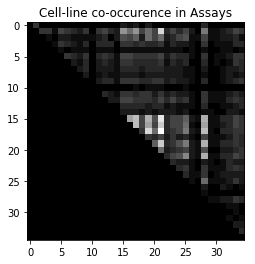

In [13]:
lc = np.copy(lines)
np.fill_diagonal(lc, 0)
pyplot.imshow(lc, cmap="gray")
pyplot.title("Cell-line co-occurence in Assays")

Text(0.5, 1.0, 'Normalized Assay Similarity Scores (Full Genome)')

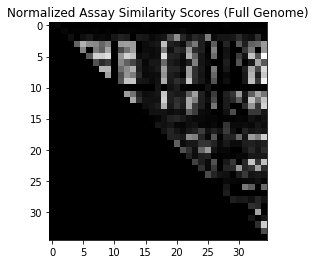

In [23]:
normalized = np.copy(dot_prods)
for i in range(35):
    for j in range(i, 35):
        if not lines[i, j]:
            continue
        normalized[i, j] /= (np.sqrt(dot_prods[i, i] * dot_prods[j, j]))
np.fill_diagonal(normalized, 0)
pyplot.imshow(normalized, cmap="gray")
pyplot.title("Normalized Assay Similarity Scores (Full Genome)")

In [19]:
np.savez("FullChromASS.npz", ass=dot_prods, occurence=lines)

In [ ]:
%%time
line_dot_prods = np.zeros((51, 51), dtype=np.double)
assays = np.zeros((51, 51), dtype=np.int32)
tasks = []
for i in range(1, 52):
    for j in range(i, 52):
        tasks.append((i, j))

with mp.Pool(min(len(tasks), 128)) as pool:
    results = pool.starmap(dot_lines, tasks)
for l1, l2, total, count in results:
    line_dot_prods[l1 - 1, l2 - 1] = total
    assays[l1 - 1, l2 - 1] = count

In [ ]:
assay_copy = np.copy(assays)
np.fill_diagonal(assay_copy, 0)
pyplot.imshow(assay_copy, cmap="gray")
pyplot.title("Assay co-occurence in cell lines")

In [ ]:
line_normalized = np.copy(line_dot_prods)
for i in range(51):
    for j in range(i, 51):
        line_normalized[i, j] /= np.sqrt(line_dot_prods[i, i] * line_dot_prods[j, j])
np.fill_diagonal(line_normalized, 0)
pyplot.imshow(line_normalized, cmap="gray")
pyplot.title("Normalized Cell Similarity Score")